In [ ]:
# Import các thư viện cần thiết
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler

# Load dữ liệu
data = pd.read_csv('/content/drive/MyDrive/Book5.csv')

df = pd.DataFrame(data)

# Chuyển cột 'Date' sang định dạng datetime
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')

# Đặt cột 'Date' làm chỉ số cho DataFrame
df.set_index('Date', inplace=True)

# Hiển thị một số hàng đầu của dataframe
print(df.head())
# chia dữ liệu theo tuần
df = df.resample('W').sum()
# Thống kê mô tả
print(df.describe())

# Kiểm tra giá trị thiếu
print(df.isnull().sum())
print(df['Order_Demand'].dtype)
if df['Order_Demand'].dtype != 'O':
    df['Order_Demand'] = df['Order_Demand'].astype(str)
# Xử lý cột 'Order_Demand' để loại bỏ các ký tự không phải số
df['Order_Demand'] = pd.to_numeric(df['Order_Demand'].str.replace(r'[^0-9-]', '', regex=True), errors='coerce')

df.columns

# Tính IQR cho cột 'Order_Demand'
Q1 = df['Order_Demand'].quantile(0.25)
Q3 = df['Order_Demand'].quantile(0.75)
IQR = Q3 - Q1

# Lọc và thay thế outlier
df['Order_Demand'] = df['Order_Demand'].apply(lambda x: max(x, Q1 - 1.5 * IQR) if x < Q1 - 1.5 * IQR else min(x, Q3 + 1.5 * IQR) if x > Q3 + 1.5 * IQR else x)





            Order_Demand
Date                    
2012-07-27           100
2012-09-13           300
2012-09-19           500
2012-10-09           300
2012-11-08           200
       Order_Demand
count    258.000000
mean     196.511628
std      240.029671
min        0.000000
25%        0.000000
50%      100.000000
75%      300.000000
max     1400.000000
Order_Demand    0
dtype: int64
int64


In [ ]:
print(df.columns)


Index(['Order_Demand'], dtype='object')


In [ ]:
print(df.dtypes)


Order_Demand    float64
dtype: object


In [ ]:
df

,Order_Demand
Date,
2012-01-22,100.0
2012-01-29,0.0
2012-02-05,0.0
2012-02-12,100.0
2012-02-19,0.0
...,...
2016-11-27,0.0
2016-12-04,300.0
2016-12-11,200.0


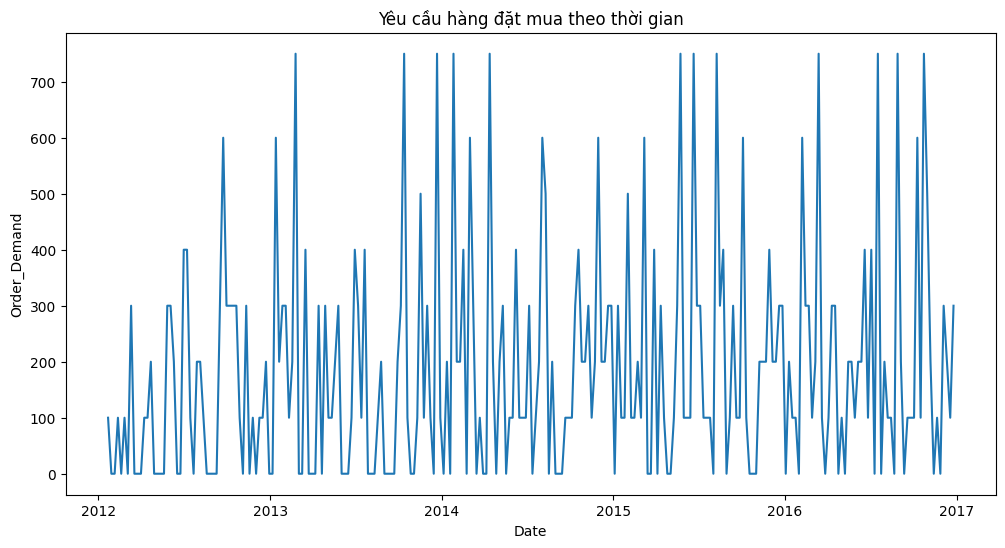

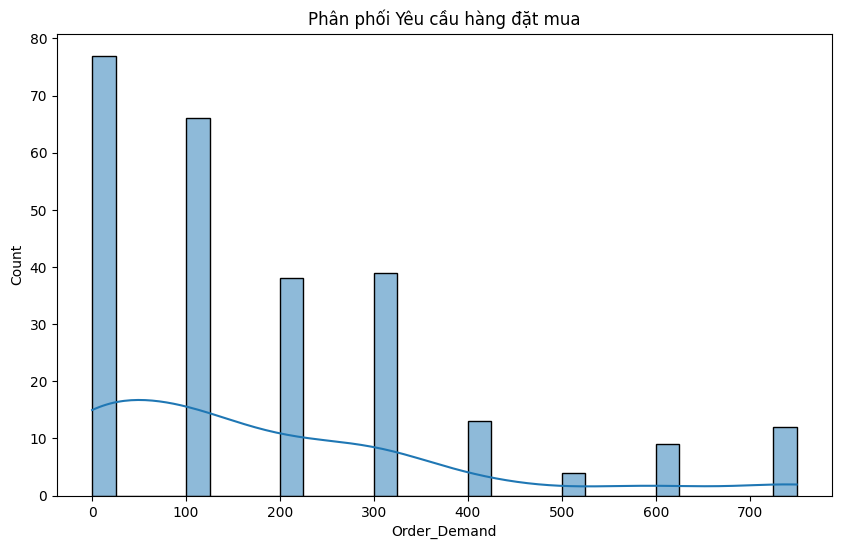

In [ ]:
# EDA - Biểu đồ dạng chuỗi thời gian của Order_Demand
plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='Order_Demand', data=df)
plt.title('Yêu cầu hàng đặt mua theo thời gian')
plt.show()

# EDA - Phân phối của Order_Demand
plt.figure(figsize=(10, 6))
sns.histplot(df['Order_Demand'], bins=30, kde=True)
plt.title('Phân phối Yêu cầu hàng đặt mua')
plt.show()

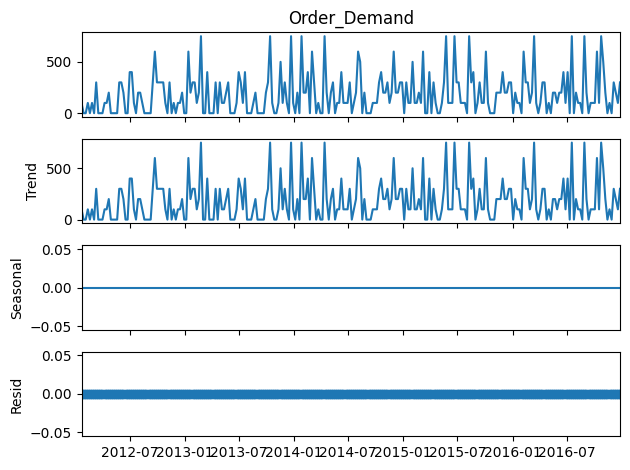

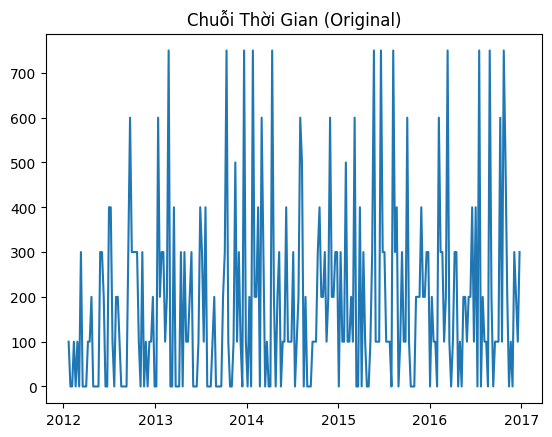

ADF Statistic (After Differencing): -16.092428383016674
p-value: 5.235920131213846e-29
Critical Values: {'1%': -3.4560535712549925, '5%': -2.8728527662442334, '10%': -2.5727985212493754}
Kết luận: Chuỗi thời gian sau sai phân là dừng


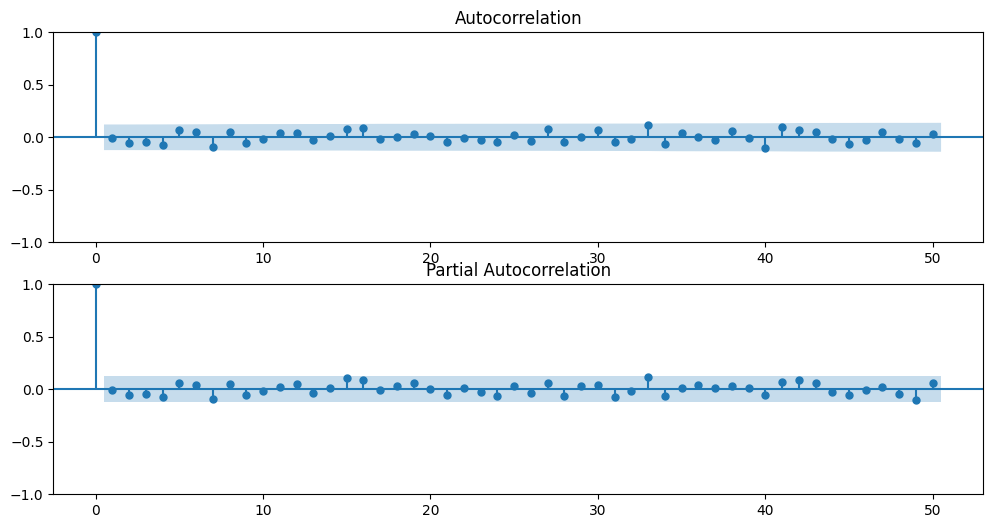

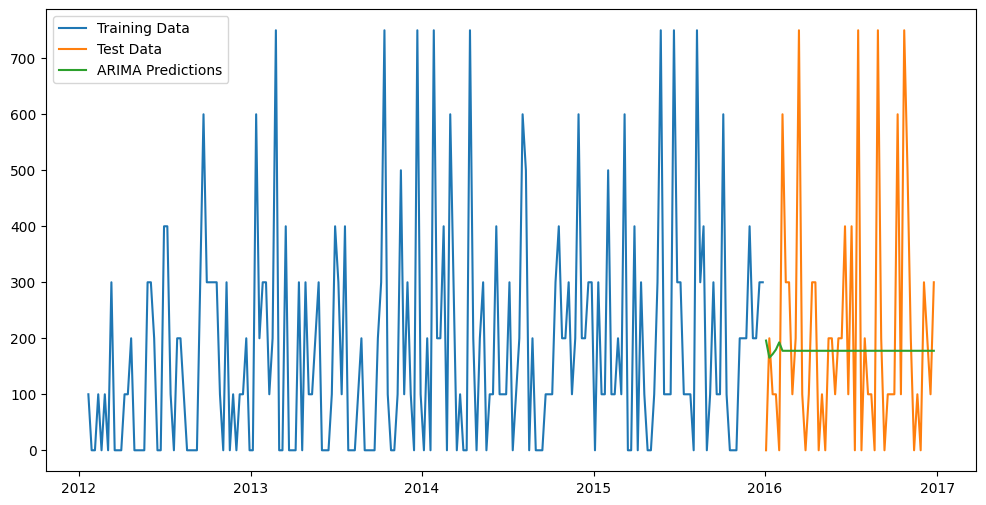

In [ ]:

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# EDA - Phân tích chuỗi thời gian
# Phân rã chuỗi thời gian để kiểm tra xu hướng và mùa vụ
result = seasonal_decompose(df['Order_Demand'], model='additive', period=1)


result.plot()
plt.show()


# Hiển thị biểu đồ chuỗi thời gian
plt.plot(df['Order_Demand'])
plt.title('Chuỗi Thời Gian (Original)')
plt.show()




from statsmodels.tsa.stattools import adfuller

result_diff = adfuller(df['Order_Demand'].dropna())

# In kết quả kiểm định sau sai phân
print('ADF Statistic (After Differencing):', result_diff[0])
print('p-value:', result_diff[1])
print('Critical Values:', result_diff[4])

# Kiểm tra kết quả và đưa ra kết luận về tính dừng
if result_diff[1] <= 0.05:
    print("Kết luận: Chuỗi thời gian sau sai phân là dừng")
else:
    print("Kết luận: Chuỗi thời gian sau sai phân không phải là dừng")


# EDA - Kiểm tra hàm tương quan tự hồi quy (ACF) và hàm tương quan riêng (PACF)
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(df['Order_Demand'], lags=50, ax=plt.gca())
plt.subplot(2, 1, 2)
plot_pacf(df['Order_Demand'], lags=50, ax=plt.gca())
plt.show()

from statsmodels.tsa.arima.model import ARIMA

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
train_size = int(len(df) * 0.8)
train, test = df['Order_Demand'][:train_size], df['Order_Demand'][train_size:]

# Xây dựng mô hình ARIMA
model = ARIMA(train, order=(0, 0, 5))  # Điều chỉnh order dựa trên ACF và PACF
fit_model = model.fit()

# Dự báo trên tập kiểm tra
predictions = fit_model.forecast(steps=len(test))

# So sánh dự báo với thực tế
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Data')
plt.plot(predictions, label='ARIMA Predictions')
plt.legend()
plt.show()



In [ ]:
from sklearn.metrics import mean_absolute_error
import numpy as np

# Tính MAPE
mape = mean_absolute_error(test, predictions) / np.mean(test) * 100
print('Mean Absolute Percentage Error (MAPE):', mape)


Mean Absolute Percentage Error (MAPE): 74.28432747593068


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
